In [59]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score


# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
|: ------------- |:-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants with higher education level
4. Properties in urban areas with high growth perspectives

Do more brainstorming and create some hypotheses of your own. Remember that the data might not be sufficient to test all of these, but forming these enables a better understanding of the problem.

- Applicants with high net worth
- Applicants that have collateral

## 2. Data Exploration
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

In [2]:
df = pd.read_csv("data/data.csv") 
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [3]:

X = df.drop(['Loan_ID', 'Loan_Status'],axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


One of the key challenges in any data set are missing values. Lets start by checking which columns contain missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
nulls = df.isnull().sum()
percent_null = (nulls/df.shape[0]) * 100
pd.DataFrame({'nulls': nulls, 'percent null': percent_null})


,nulls,percent null
Loan_ID,0,0.000000
Gender,13,2.117264
Married,3,0.488599
Dependents,15,2.442997
Education,0,0.000000
Self_Employed,32,5.211726
ApplicantIncome,0,0.000000
CoapplicantIncome,0,0.000000
LoanAmount,22,3.583062
Loan_Amount_Term,14,2.280130


Look at some basic statistics for numerical variables.

In [6]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [7]:
df.median()

/tmp/ipykernel_53283/530051474.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.median()


ApplicantIncome      3812.5
CoapplicantIncome    1188.5
LoanAmount            128.0
Loan_Amount_Term      360.0
Credit_History          1.0
dtype: float64

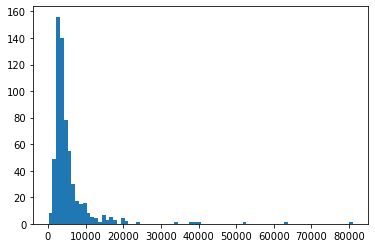

In [8]:
plt.hist(df['ApplicantIncome'], bins=80)
plt.show()

1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise)

    - 564 out of 614

2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`?

    - min 150 and max 81000.
    - some very high income outliers

3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature.

    - mean (5403) is higher than median (3812) because of these very high income outliers


Let's discuss nominal (categorical) variable. Look at the number of unique values in each of them.

In [9]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [45]:
cat_cols = ['Gender',
            'Married',
            'Dependents',
            'Education',
            'Self_Employed',
            'Loan_Amount_Term',
            'Credit_History',
            'Property_Area',
            'Loan_Status']

In [46]:
df[cat_cols].nunique()

Gender               2
Married              2
Dependents           4
Education            2
Self_Employed        2
Loan_Amount_Term    10
Credit_History       2
Property_Area        3
Loan_Status          2
dtype: int64

Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

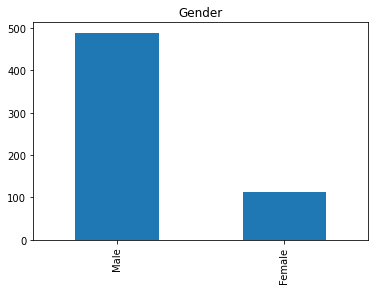

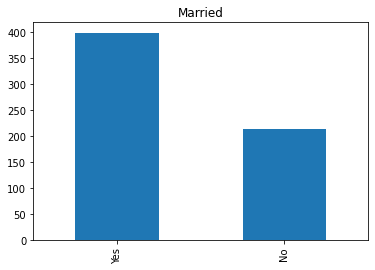

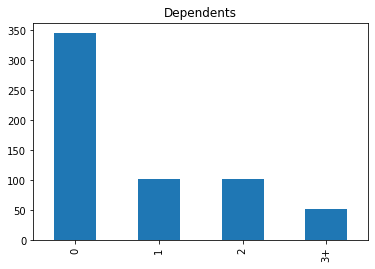

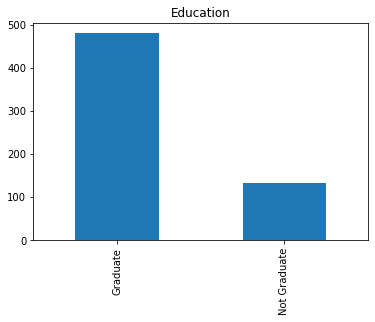

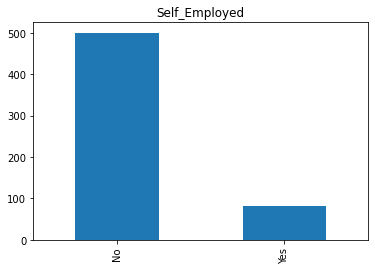

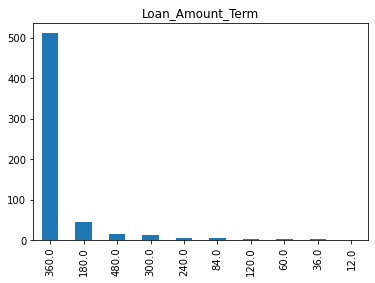

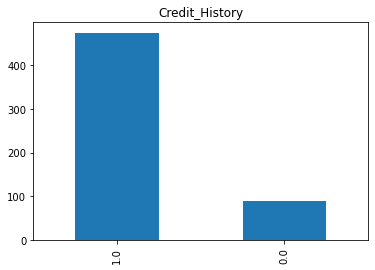

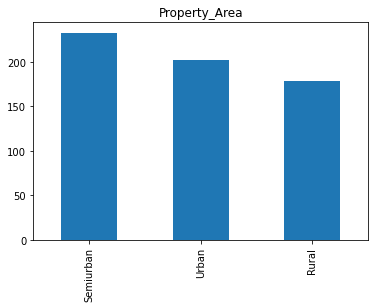

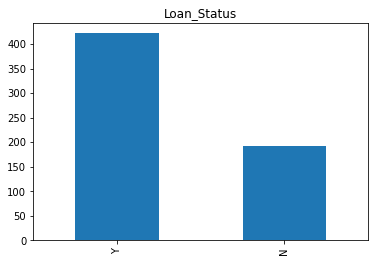

In [47]:
for col in cat_cols:
    df[col].value_counts().plot(kind='bar', title=col)
    
    plt.show()

### Distribution analysis

Study distribution of various variables. Plot the histogram of ApplicantIncome, try different number of bins.



In [13]:
numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
numeric_cols

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

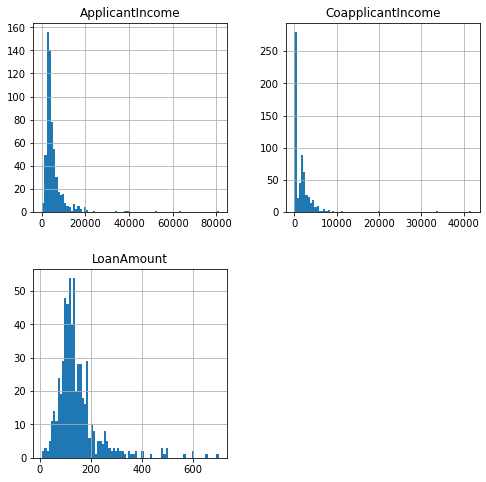

In [14]:
df[numeric_cols].hist(bins=80,figsize=(8, 8))
plt.show()


Look at box plots to understand the distributions. 

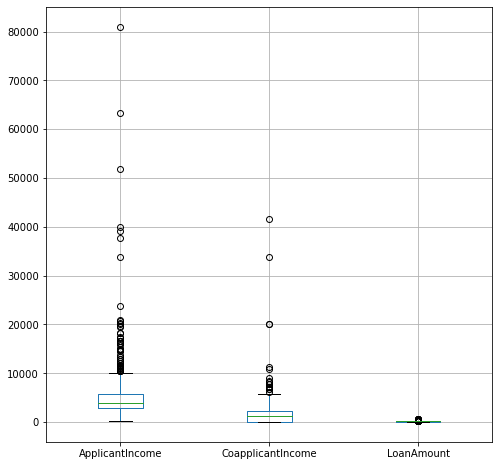

In [15]:
df.boxplot(numeric_cols,figsize=(8, 8))
plt.show()

Look at the distribution of income segregated  by `Education`

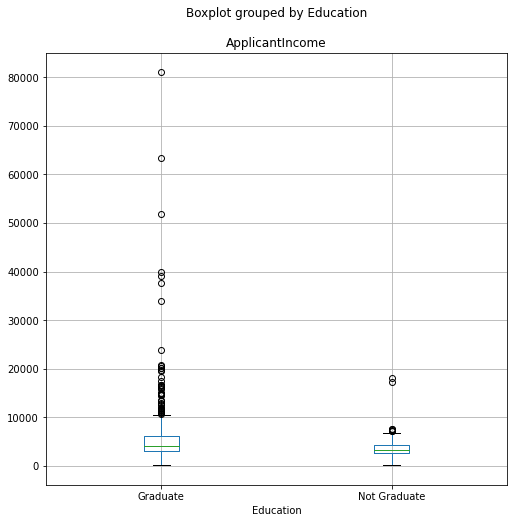

In [16]:
df.boxplot('ApplicantIncome', by='Education',figsize=(8, 8))
plt.show()

Look at the histogram and boxplot of LoanAmount

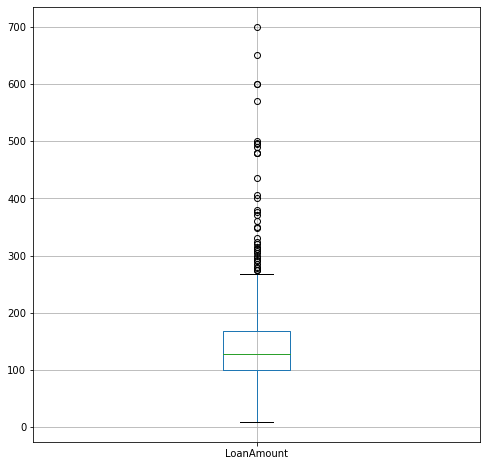

In [106]:
df.boxplot('LoanAmount', figsize=(8, 8))
plt.show()

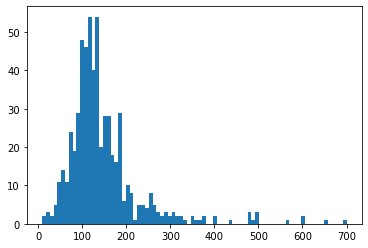

In [17]:
plt.hist(df['LoanAmount'], bins=80)
plt.show()

There might be some extreme values. Both `ApplicantIncome` and `LoanAmount` require some amount of data munging. `LoanAmount` has missing and well as extreme values values, while `ApplicantIncome` has a few extreme values, which demand deeper understanding. 

### Categorical variable analysis

Try to understand categorical variables in more details using `pandas.DataFrame.pivot_table` and some visualizations.

## 3. Data Cleaning

This step typically involves imputing missing values and treating outliers. 

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.



Impute missing values for all columns. Use the values which you find most meaningful (mean, mode, median, zero.... maybe different mean values for different groups)

In [18]:
most_freq_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Property_Area','Dependents']
mean_cols = ['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome']
zero_cols = ['Credit_History']


column_trans = ColumnTransformer([('imp_most_freq', SimpleImputer(strategy='most_frequent', missing_values=np.nan), most_freq_cols),
                                 ('imp_mean', SimpleImputer(strategy='mean', missing_values=np.nan), mean_cols),
                                 ('imp_zero', SimpleImputer(strategy='constant', fill_value=0), zero_cols)
                                 ],
                                remainder='passthrough')

In [19]:
X_train_filled = column_trans.fit_transform(X_train)
df_filled = pd.DataFrame(X_train_filled)
df_filled.isnull().any()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
dtype: bool

### Extreme values
Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

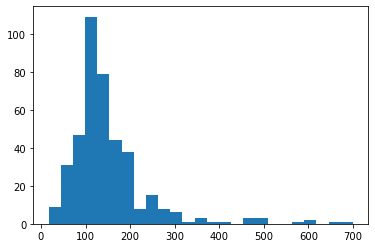

In [20]:
plt.hist(X_train['LoanAmount'], bins=25)
plt.show()

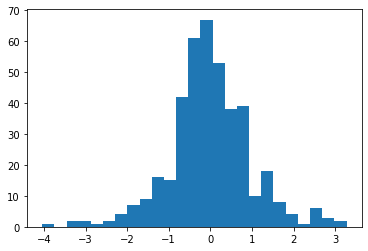

In [21]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
# data_trans = power.fit_transform([df_filled[6]])
# histogram of the transformed data

column_trans_log = ColumnTransformer([('powert_trans', power, ['LoanAmount']),
                                 ],
                                remainder='passthrough')

X_train_log = column_trans_log.fit_transform(X_train)
df_filled = pd.DataFrame(X_train_log)
plt.hist(df_filled[0], bins=25)
plt.show()

In [ ]:
# def log_transform(x):
#     return np.log(x + 1)


# scaler = StandardScaler()
# transformer = FunctionTransformer(log_transform)

Combine both incomes as total income and take a log transformation of the same.

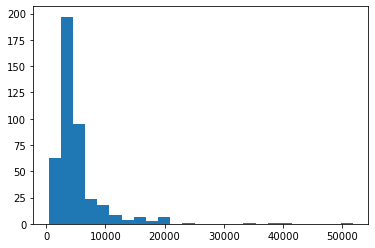

In [22]:
plt.hist(X_train['ApplicantIncome'], bins=25)
plt.show()

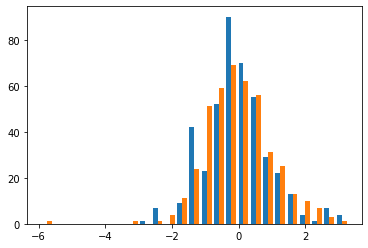

In [23]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
# data_trans = power.fit_transform([df_filled[6]])
# histogram of the transformed data

column_trans_log = ColumnTransformer([('powert_trans', power, ['LoanAmount']),
                                      ('powert_trans1', power, ['ApplicantIncome']),
                                 ],
                                remainder='passthrough')

X_train_log = column_trans_log.fit_transform(X_train)
df_filled = pd.DataFrame(X_train_log)
df_filled
plt.hist(df_filled[[0,1]], bins=25)
plt.show()

In [31]:
cat_pipeline = Pipeline([('impute_frequent', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
                         ('ohe', OneHotEncoder(sparse=False))])
cat_pipeline.fit_transform(X_test[most_freq_cols]).shape


(185, 21)

## 4. Building a Predictive Model

score: 0.772972972972973
recall: 0.925
precision 0.7708333333333334


TypeError: roc_auc_score() got an unexpected keyword argument 'pos_label'

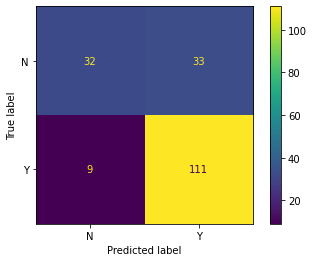

In [62]:
most_freq_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Property_Area','Dependents']
mean_cols = ['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome']
zero_cols = ['Credit_History']

# pipelines for cat columns and numeric columns
cat_pipeline = Pipeline([('impute_frequent', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
                         ('ohe', OneHotEncoder(drop='if_binary', sparse=False))])

num_pipeline = Pipeline([('impute_mean', SimpleImputer(strategy='mean', missing_values=np.nan)),
                         ('power_trans', PowerTransformer(method='yeo-johnson', standardize=True))])
                       
credit_hist_pipeline = Pipeline([('impute_zero', SimpleImputer(strategy='constant', fill_value=0)),
                                 ('ohe', OneHotEncoder(sparse=False))])

# final pipeline
pipeline = Pipeline([('preprocess', ColumnTransformer([('cat', cat_pipeline, most_freq_cols),
                                                       ('num', num_pipeline, mean_cols),
                                                       ('credit', credit_hist_pipeline, zero_cols)],
                                                        remainder='passthrough')),
                     ('pca', PCA(n_components=6)),
                     ('classifier',  LogisticRegression(random_state=42))])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# analysis
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print('score:',pipeline.score(X_test, y_test))
print('recall:', recall_score(y_test, y_pred,pos_label="Y"))
print('precision', precision_score(y_test, y_pred, pos_label='Y'))
print('roc-auc:', roc_auc_score(y_test, y_pred, pos_label='Y'))

Try paramater grid search to improve the results

Fitting 5 folds for each of 108 candidates, totalling 540 fits
score: 0.7405405405405405
recall: 0.9333333333333333
precision 0.7368421052631579
{'classifier__C': 0.1, 'classifier__max_iter': 300, 'pca__n_components': 12}


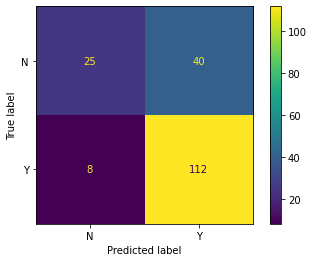

In [40]:
most_freq_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Property_Area','Dependents']
mean_cols = ['LoanAmount', 'ApplicantIncome', 'CoapplicantIncome']
zero_cols = ['Credit_History']

# pipelines for cat columns and numeric columns
cat_pipeline = Pipeline([('impute_frequent', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
                         ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

num_pipeline = Pipeline([('impute_mean', SimpleImputer(strategy='mean', missing_values=np.nan)),
                         ('power_trans', PowerTransformer(method='yeo-johnson', standardize=True))])
                       
credit_hist_pipeline = Pipeline([('impute_zero', SimpleImputer(strategy='constant', fill_value=0)),
                                 ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# final pipeline
pipeline = Pipeline([('preprocess', ColumnTransformer([('cat', cat_pipeline, most_freq_cols),
                                                       ('num', num_pipeline, mean_cols),
                                                       ('credit', credit_hist_pipeline, zero_cols)],
                                                        remainder='passthrough')),
                     ('pca', PCA(n_components=6)),
                     ('classifier',  LogisticRegression(random_state=42))])


params = [{'pca__n_components': [4, 6, 8, 10, 12, 14],
          'classifier__C': [0.001, 0.01, 0.1, 1, 10 ],
          'classifier__max_iter': [300, 500, 700]},
         {'pca__n_components': [4, 6, 8, 10, 12, 14],
          'classifier__penalty': ['none'],
          'classifier__max_iter': [300, 500, 700]}]

# Train the grid search model
gs = GridSearchCV(pipeline, params, verbose=1, refit=True)

gs.fit(X_train, y_train)

y_pred = gs.predict(X_test)

# analysis
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print('score:',gs.score(X_test, y_test))
print('recall:', recall_score(y_test, y_pred,pos_label="Y"))
print('precision', precision_score(y_test, y_pred, pos_label='Y'))
print(gs.best_params_)

In [44]:
#coefficients of fitted model
gs.best_estimator_.named_steps['classifier'].coef_

array([[-0.0974489 , -0.027619  ,  0.22248028, -0.97135436,  0.10793929,
        -0.35743371,  0.43987235, -0.01392228, -0.15626161,  0.18843603,
         0.29284671, -0.10122026]])

In [256]:
with open('log_reg_model.sav', 'wb') as fh:
    pickle.dump(gs, fh)
    
with open('log_reg_model.sav', 'rb') as openfile:
    model_load = pickle.load(openfile)

## 5. Using Pipeline
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

In [ ]:
# see above 

## 6. Deploy your model to cloud and test it with PostMan, BASH or Python

array(['Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N',
       'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y',
       'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N',
       'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'N', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y